## JupyterSDRDisplay Test Notebook:
> - continuous spectrogram spectrum from stick (use demo_waterfall.py as base).
> - finds frequencies in the spectrogram that fit a model (avg db, snr, on, etc...)
> - assigns a worker to monitor the frquencies that 'fit' the model.
>   - worker records, catalogs signal when receiving a broadccast on assigned frequency
>   - workers with signals are displayed in the spectrogram UI.

In [7]:
%matplotlib inline

In [8]:
from __future__ import division
import matplotlib.animation as animation
from matplotlib.mlab import psd
import pylab as pyl
import numpy as np
import sys
from rtlsdr import RtlSdr

In [ ]:
# A simple waterfall, spectrum plotter
#
# Controls:
#
# * Scroll mouse-wheel up or down, or press the left or right arrow keys, to
#   change the center frequency (hold shift for finer control).
# * Press "+" and "-" to control gain, and space to enable AGC.
# * Type a frequency (in MHz) and press enter to directly change the center frequency

In [9]:
NFFT = 1024*4
NUM_SAMPLES_PER_SCAN = NFFT*16
NUM_BUFFERED_SWEEPS = 100

# change this to control the number of scans that are combined in a single sweep
# (e.g. 2, 3, 4, etc.) Note that it can slow things down
NUM_SCANS_PER_SWEEP = 1

# these are the increments when scrolling the mouse wheel or pressing '+' or '-'
FREQ_INC_COARSE = 1e6
FREQ_INC_FINE = 0.1e6
GAIN_INC = 5

In [10]:
class Waterfall(object):
    keyboard_buffer = []
    shift_key_down = False
    image_buffer = -100*np.ones((NUM_BUFFERED_SWEEPS,\
                                 NUM_SCANS_PER_SWEEP*NFFT))

    def __init__(self, sdr=None, fig=None):
        self.fig = fig if fig else pyl.figure()
        self.sdr = sdr if sdr else RtlSdr()

        self.init_plot()

    def init_plot(self):
        self.ax = self.fig.add_subplot(1,1,1)
        self.image = self.ax.imshow(self.image_buffer, aspect='auto',\
                                    interpolation='nearest', vmin=-50, vmax=10)
        self.ax.set_xlabel('Current frequency (MHz)')
        self.ax.get_yaxis().set_visible(False)

        self.fig.canvas.mpl_connect('scroll_event', self.on_scroll)
        self.fig.canvas.mpl_connect('key_press_event', self.on_key_press)
        self.fig.canvas.mpl_connect('key_release_event', self.on_key_release)

    def update_plot_labels(self):
        fc = self.sdr.fc
        rs = self.sdr.rs
        freq_range = (fc - rs/2)/1e6, (fc + rs*(NUM_SCANS_PER_SWEEP - 0.5))/1e6

        self.image.set_extent(freq_range + (0, 1))
        self.fig.canvas.draw_idle()

    def on_scroll(self, event):
        if event.button == 'up':
            self.sdr.fc += FREQ_INC_FINE if self.shift_key_down else FREQ_INC_COARSE
            self.update_plot_labels()
        elif event.button == 'down':
            self.sdr.fc -= FREQ_INC_FINE if self.shift_key_down else FREQ_INC_COARSE
            self.update_plot_labels()

    def on_key_press(self, event):
        if event.key == '+':
            self.sdr.gain += GAIN_INC
        elif event.key == '-':
            self.sdr.gain -= GAIN_INC
        elif event.key == ' ':
            self.sdr.gain = 'auto'
        elif event.key == 'shift':
            self.shift_key_down = True
        elif event.key == 'right':
            self.sdr.fc += FREQ_INC_FINE if self.shift_key_down else FREQ_INC_COARSE
            self.update_plot_labels()
        elif event.key == 'left':
            self.sdr.fc -= FREQ_INC_FINE if self.shift_key_down else FREQ_INC_COARSE
            self.update_plot_labels()
        elif event.key == 'enter':
            # see if valid frequency was entered, then change center frequency
            try:
                # join individual key presses into a string
                input = ''.join(self.keyboard_buffer)

                # if we're doing multiple adjacent scans, we need to figure out
                # the appropriate center freq for the leftmost scan
                center_freq = float(input)*1e6 + (self.sdr.rs/2)*(1 - NUM_SCANS_PER_SWEEP)
                self.sdr.fc = center_freq

                self.update_plot_labels()
            except ValueError:
                pass

            self.keyboard_buffer = []
        else:
            self.keyboard_buffer.append(event.key)

    def on_key_release(self, event):
        if event.key == 'shift':
            self.shift_key_down = False

    def update(self, *args):
        # save center freq. since we're gonna be changing it
        start_fc = self.sdr.fc

        # prepare space in buffer
        # TODO: use indexing to avoid recreating buffer each time
        self.image_buffer = np.roll(self.image_buffer, 1, axis=0)

        for scan_num, start_ind in enumerate(range(0, NUM_SCANS_PER_SWEEP*NFFT, NFFT)):
            self.sdr.fc += self.sdr.rs*scan_num

            # estimate PSD for one scan
            samples = self.sdr.read_samples(NUM_SAMPLES_PER_SCAN)
            psd_scan, f = psd(samples, NFFT=NFFT)

            self.image_buffer[0, start_ind: start_ind+NFFT] = 10*np.log10(psd_scan)

        # plot entire sweep
        self.image.set_array(self.image_buffer)

        # restore original center freq.
        self.sdr.fc = start_fc

        return self.image,

    def start(self):
        self.update_plot_labels()
        if sys.platform == 'darwin':
            # Disable blitting. The matplotlib.animation's restore_region()
            # method is only implemented for the Agg-based backends,
            # which the macosx backend is not.
            blit = False
        else:
            blit = True
        ani = animation.FuncAnimation(self.fig, self.update, interval=50,
                blit=blit)

        pyl.show()

        return

In [11]:
def main():
    sdr = RtlSdr()
    wf = Waterfall(sdr)

    # some defaults
    sdr.rs = 2.4e6
    sdr.fc = 100e6
    sdr.gain = 10

    wf.start()

    # cleanup
    sdr.close()

Found Rafael Micro R820T/2 tuner
/var/folders/x0/fmsrnw9x6qn029557vvlnh380000gn/T/ipykernel_57887/3577499985.py:112: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(self.fig, self.update, interval=50,


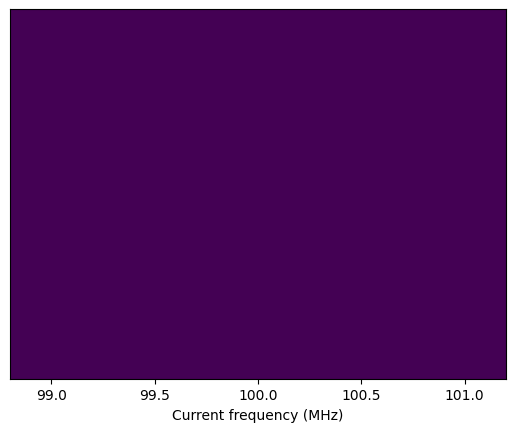

In [12]:
if __name__ == '__main__':
    main()